In [1]:
import os
import pathlib
import numpy as np
from tensorflow.keras import *
from keras.preprocessing import image


path = os.path.join(os.getcwd(),'Linnaeus5128X128')
print(path)

C:\Users\mdsp\Desktop\INF573\Linnaeus5128X128


In [2]:
os.chdir(path)

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2958728739987935892
xla_global_id: -1
]


In [4]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.7.0


In [5]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [6]:
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

print(test_path)

C:\Users\mdsp\Desktop\INF573\Linnaeus5128X128\test


In [7]:
def make_dataset(kind_of_data) :
    X = []
    Y = []
    if kind_of_data == 'train' :
        new_path = train_path
    elif kind_of_data == 'test' :
        new_path = test_path
    else :
        return 0
    
    os.chdir(new_path)
    folders = os.listdir()
    folder_paths = []
    
    for folder in range(len(folders)):
      folder_paths = os.path.join(new_path,folders[folder])
      os.chdir(folder_paths)
      image_in_folder = os.listdir()
      for i in range(len(image_in_folder)):
          img = keras.preprocessing.image.load_img(str(image_in_folder[i]))
          img = keras.preprocessing.image.img_to_array(img)
          X.append(img)
          Y.append(folder)
              
    return X, Y

In [8]:
x_train, y_train = make_dataset('train')

In [9]:
x_test, y_test = make_dataset('test')

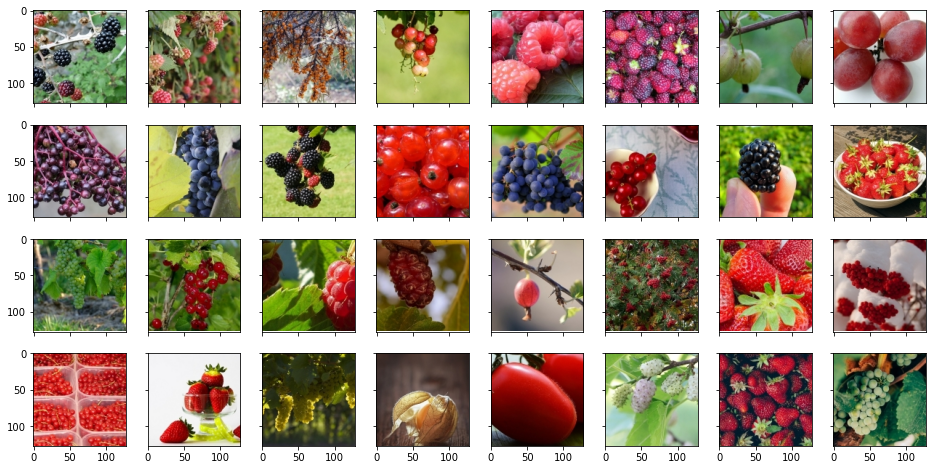

In [10]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 8), 
                 axes_pad=0.3,  
                 )

for ax, img, label in zip(grid, sample_images, sample_labels):
  ax.imshow(img.astype(np.uint8))

plt.show()

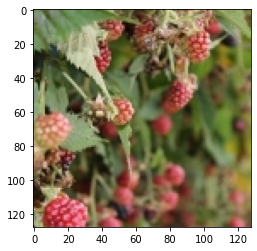

In [85]:
sample_images = x_train[:32]
testimage = sample_images[1]
plt.imshow(testimage.astype(np.uint8))

In [82]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=128, dim=(128, 128), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):

    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) 
    
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) 

    
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
    
      masked_image, mask = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    
    mask = np.full((128,128,3), 255, np.uint8) 
    for _ in range(int(0.5*(128*128))):
      x1, y1 = np.random.randint(1, 128), np.random.randint(1, 128)
      mask[x1,y1] = [0,0,0]

    masked_image = img.copy()
    masked_image[mask==0] = 255
    return masked_image,mask

In [13]:
# def createMask(img, p = 0.5):
#     assert p > 0 and p < 1, 'The probability value should lie in (0, 1)'
#     mask = np.random.rand(128,128)
#     masked_image = img.copy()
#     masked_image[:, mask<p] = 0
#     mask = mask > p
#     mask = mask.repeat(1,1,3)

#     return masked_image, mask

In [14]:
def createMask(img):
    mask = np.full((128,128,3), 255, np.uint8)
    for _ in range(int(0.5*(128*128))):
      x1, y1 = np.random.randint(1, 128), np.random.randint(1, 128)
      mask[x1,y1] = [0,0,0]

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255
    return masked_image

In [16]:
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

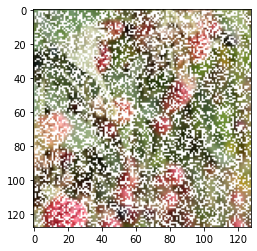

In [33]:
masked_image = createMask(sample_images[1])
plt.imshow(masked_image.astype(np.uint8))

## Autoencoder-Decoder Model

In [19]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [20]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,3)):
    inputs = keras.layers.Input(input_size)
    print(inputs.shape)
    conv1, pool1 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(512, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(1024, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(1024, 1024, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(512, 512, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(256, 256, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(128, 128, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [21]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
#keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model.png')

(None, 128, 128, 3)


# Train

In [22]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        sample_images, sample_labels = testgen[sample_idx]  
        
        images = []
        labels = []
        predictions = []
        
        for i in range():
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))

In [23]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=8, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen))

Epoch 1/8
46/46 [==============================] - 10718s 233s/step - loss: 0.1273 - dice_coef: 0.5391 - val_loss: 0.0779 - val_dice_coef: 0.5867
Epoch 2/8
46/46 [==============================] - 10256s 223s/step - loss: 0.0659 - dice_coef: 0.5873 - val_loss: 0.0519 - val_dice_coef: 0.5892
Epoch 3/8
46/46 [==============================] - 10426s 227s/step - loss: 0.0510 - dice_coef: 0.5949 - val_loss: 0.0442 - val_dice_coef: 0.5993
Epoch 4/8
46/46 [==============================] - 10471s 228s/step - loss: 0.0454 - dice_coef: 0.5973 - val_loss: 0.0442 - val_dice_coef: 0.5933
Epoch 5/8
46/46 [==============================] - 10518s 229s/step - loss: 0.0413 - dice_coef: 0.5996 - val_loss: 0.0377 - val_dice_coef: 0.5923
Epoch 6/8
46/46 [==============================] - 11878s 259s/step - loss: 0.0382 - dice_coef: 0.6015 - val_loss: 0.0394 - val_dice_coef: 0.5910
Epoch 7/8
46/46 [==============================] - 26027s 572s/step - loss: 0.0342 - dice_coef: 0.6018 - val_loss: 0.0325 - 

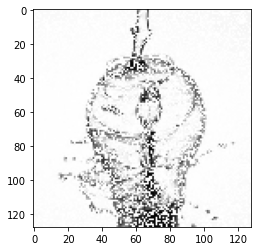

In [54]:
masked_image1 = createMask(sample_images[50])
plt.imshow(masked_image1.astype(np.uint8))

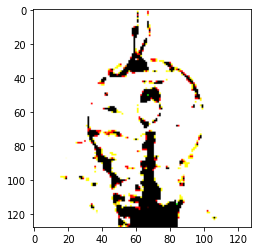

In [78]:
resulting = model.predict(masked_image1.reshape((1,)+masked_image.shape))
plt.imshow(resulting.reshape(resulting.shape[1:]))